Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


R-squared: 0.9554179725988139


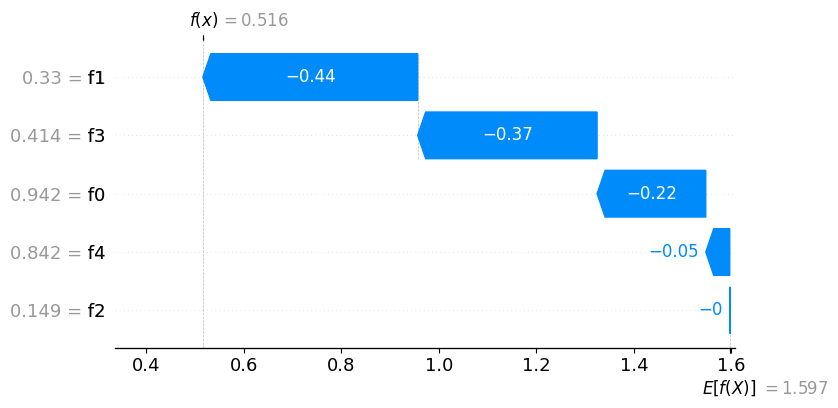

SHAP value saved at linear_shap_values.csv


In [1]:
from sklearn.cluster import KMeans
import pandas as pd
import shap
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

train_data = pd.read_csv('train_pts.csv')
test_data = pd.read_csv('test_pts.csv')

# 定义特征和标签
X_train = train_data.drop(columns='y')
y_train = train_data['y']
X_test = test_data.drop(columns='y')
y_test = test_data['y']

# 再次确认数据加载正确
train_data.head(), test_data.head()

# 训练线性回归模型
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# 进行预测
y_pred = linear_model.predict(X_test)

# 计算 R² 值
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

# 初始化SHAP解释器
explainer = shap.Explainer(linear_model, X_train)

# 计算测试集的SHAP值
shap_values = explainer(X_test)

# 可视化第一个样本的SHAP值（例如）
shap.plots.waterfall(shap_values[0])

# 保存SHAP值到DataFrame（可选）
# 注意：shap_values.values 返回一个数组，其中包含了测试集每个样本的SHAP值
shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)

# 将SHAP值保存到CSV文件
linear_shap_values = 'linear_shap_values.csv'
shap_values_df.to_csv(linear_shap_values, index=False)
print(f"SHAP value saved at {linear_shap_values}")

# 获取线性模型的系数，这些系数可以视为特征重要性
linear_coef = linear_model.coef_

In [2]:
# 使用 SHAP 值来进行聚类
# 首先得到一个 (n_samples, n_features) 形状的数组
# use SHAP value to cluster
shap_values_array = shap_values.values

# 使用 KMeans 进行聚类
# use KMeans to cluster
kmeans_shap = KMeans(n_clusters=3, random_state=42)
shap_clusters = kmeans_shap.fit_predict(shap_values_array)

# 将聚类结果添加到 SHAP 值 DataFrame 中
# add result to shaps value DataFrame
shap_values_df['Cluster'] = shap_clusters

# 输出聚类结果
# output cluster result
print(shap_values_df)

# 将包含聚类结果的SHAP值保存到CSV文件
# save shap_values_with_clusters
shap_clusters_csv_path = 'linear_shap_values_with_clusters.csv'
shap_values_df.to_csv(shap_clusters_csv_path, index=False)
print(f"shap_values_with_clusters have been saved at {shap_clusters_csv_path}")

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


           f0        f1        f2        f3        f4  Cluster
0   -0.222898 -0.440580 -0.000672 -0.367972 -0.049189        0
1    0.106870 -0.076359 -0.000196  0.140876  0.015764        1
2    0.121546  0.211407  0.000413  0.433783  0.069918        2
3    0.363699  0.472936  0.000331  0.443839  0.101697        2
4   -0.431296 -0.408209 -0.000634 -0.260593 -0.064550        0
..        ...       ...       ...       ...       ...      ...
370  0.174967  0.457270  0.000249  0.171923  0.081976        2
371 -0.089552  0.023526 -0.000184 -0.038140  0.026075        1
372 -0.150868  0.020857  0.000004  0.011081  0.027849        1
373 -0.448819 -0.190488 -0.000539 -0.279827 -0.065180        0
374  0.358328  0.336764  0.000462  0.406340  0.067928        2

[375 rows x 6 columns]
shap_values_with_clusters have been saved at linear_shap_values_with_clusters.csv


In [3]:
# 分别对每个聚类的数据点进行线性回归分析
# seperately make LR for every cluster
cluster_models = []
cluster_intercepts = []
cluster_coefficients = []

for i in range(kmeans_shap.n_clusters):
    # 选择当前聚类的数据
    # choose current cluster data
    cluster_indices = shap_clusters == i
    X_cluster = X_test.iloc[cluster_indices]
    y_cluster = y_test.iloc[cluster_indices]

    # 检查聚类内是否有足够的数据点
    # check if cluster include enough data
    if len(X_cluster) > 1:
        # 创建并拟合线性回归模型
        # create and fit LR model
        cluster_model = LinearRegression()
        cluster_model.fit(X_cluster, y_cluster)

        # 存储模型的参数
        # save model parameters
        cluster_models.append(cluster_model)
        cluster_intercepts.append(cluster_model.intercept_)
        cluster_coefficients.append(cluster_model.coef_)

        # 打印每个聚类的线性方程
        # print every LR function
        coefficients = ' + '.join(f'{coef:.3f}*{name}' for coef, name in zip(cluster_model.coef_, X_train.columns))
        print(f"Cluster {i} equation: {cluster_model.intercept_:.3f} + {coefficients}")
    else:
        print(f"Cluster {i} does not have enough data points for regression.")
        cluster_models.append(None)
        cluster_intercepts.append(None)
        cluster_coefficients.append(None)

# 创建一个包含模型参数的DataFrame
# create DataFrame contain model parameters
cluster_parameters_df = pd.DataFrame({
    'Cluster': range(kmeans_shap.n_clusters),
    'Intercept': cluster_intercepts,
    'Coefficients': cluster_coefficients
})

# 输出模型参数
# output model parameter
print(cluster_parameters_df)

# 将每个聚类的模型参数保存下来
# save every cluster parameter
cluster_parameters_csv_path = 'linear_cluster_parameters.csv'
cluster_parameters_df.to_csv(cluster_parameters_csv_path, index=False)
print(f"cluster LR parameters have been saved at {cluster_parameters_csv_path}")

Cluster 0 equation: -0.025 + -0.000*f0 + -0.000*f1 + 0.000*f2 + 0.800*f3 + 0.200*f4
Cluster 1 equation: -0.025 + 0.800*f0 + 0.200*f1 + -0.000*f2 + 0.000*f3 + -0.000*f4
Cluster 2 equation: -0.025 + -0.000*f0 + 0.800*f1 + 0.000*f2 + 0.200*f3 + 0.000*f4
   Cluster  Intercept                                       Coefficients
0        0  -0.024661  [-4.521362044019269e-06, -4.485282022693656e-0...
1        1  -0.024594  [0.7999835794422584, 0.19999650490049578, -1.4...
2        2  -0.024665  [-7.227993537292787e-06, 0.7999991186170411, 6...
cluster LR parameters have been saved at linear_cluster_parameters.csv
